# Import Data:

In [ ]:
%pip install scikit-learn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pickle
import numpy as np
import gc

USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS = 950

# Load the pickle file
print("Loading datafile...")
with open("../mon_standard.pkl", 'rb') as fi:
    data = pickle.load(fi)

# Determine the total number of samples and the maximum sequence length
num_samples = sum(len(data[i]) for i in range(TOTAL_URLS))
max_length = max(len(sample) for i in range(TOTAL_URLS) for sample in data[i])

X1_mon = []
X2_mon = []
y_mon = []

for i in range(TOTAL_URLS):
    if USE_SUBLABEL:
        label = i
    else:
        label = i // URL_PER_SITE

    for sample in data[i]:
        size_seq = []
        time_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)

        X1_mon.append(time_seq)
        X2_mon.append(size_seq)
        y_mon.append(label)

print(f'Total samples: {len(y_mon)}')
# Convert to numpy arrays directly
X1_mon = np.array(X1_mon, dtype=object)
X2_mon = np.array(X2_mon, dtype=object)
y_mon = np.array(y_mon, dtype=int)

Loading datafile...
Total samples: 19000


In [2]:
import pickle

TOTAL_URLS = 10000  # total number in the dataset

# Load 10,000 unmon pickle file
print("Loading datafile...")
with open('../unmon_standard10.pkl', 'rb') as f:  # Path to unmon_standard10.pkl in Colab
    x = pickle.load(f)

size = len(x)
print(f'Total samples: {size}')

X1_unmon = [] # Array to store instances (timestamps) - 10,000 instances, e.g., [[0.0, 0.5, 3.4, ...], [0.0, 4.5, ...], [0.0, 1.5, ...], ... [... ,45.8]]
X2_unmon = [] # Array to store instances (direction*size) - size information

for i in range(TOTAL_URLS):
    size_seq = []
    time_seq = []
    for c in x[i]:
        dr = 1 if c > 0 else -1
        time_seq.append(abs(c))
        size_seq.append(dr * 512) # In the pickle file, there is no size information, so the conversion code is set to multiply by 512 uniformly.
    X1_unmon.append(time_seq)
    X2_unmon.append(size_seq)

# Convert to numpy arrays directly
X1_unmon = np.array(X1_unmon, dtype=object)
X2_unmon = np.array(X2_unmon, dtype=object)

print(len(X1_unmon)) # Print the length of X1

Loading datafile...
Total samples: 10000
10000


## Data Preparation

In [5]:
import statistics

# Packet Direction and Size Analysis
incoming_packet_count = [sum(1 for size in sub_array if size < 0) for sub_array in X2_mon]  # Incoming Packet Count
outgoing_packet_count = [sum(1 for size in sub_array if size > 0) for sub_array in X2_mon]  # Outgoing Packet Count
total_packet_count = [len(sub_array) for sub_array in X2_mon]  # Total Packet Count
fraction_incoming_packets = [incoming / len(sub_array) if len(sub_array) != 0 else 0 for incoming, sub_array in zip(incoming_packet_count, X2_mon)]  # Fraction of Incoming Packets
fraction_outgoing_packets = [outgoing / len(sub_array) if len(sub_array) != 0 else 0 for outgoing, sub_array in zip(outgoing_packet_count, X2_mon)]  # Fraction of Outgoing Packets

# Packet Ordering Statistics
avg_incoming_packet_order = [np.mean([i for i, size in enumerate(sub_array) if size < 0]) if any(size < 0 for size in sub_array) else 0 for sub_array in X2_mon]  # Avg. Incoming Packet Order
std_dev_incoming_packet_order = [np.std([i for i, size in enumerate(sub_array) if size < 0]) if any(size < 0 for size in sub_array) else 0 for sub_array in X2_mon]  # Std. Dev. Incoming Packet Order
avg_outgoing_packet_order = [np.mean([i for i, size in enumerate(sub_array) if size > 0]) if any(size > 0 for size in sub_array) else 0 for sub_array in X2_mon]  # Avg. Outgoing Packet Order
std_dev_outgoing_packet_order = [np.std([i for i, size in enumerate(sub_array) if size > 0]) if any(size > 0 for size in sub_array) else 0 for sub_array in X2_mon]  # Std. Dev. Outgoing Packet Order

# Packet Concentration and Inter-Arrival Times
packet_concentration = [np.mean(np.diff(time_seq)) if len(time_seq) > 1 else 0 for time_seq in X1_mon]  # Mean Packet Concentration
incoming_inter_arrival_stats = []
outgoing_inter_arrival_stats = []
for time_seq, size_seq in zip(X1_mon, X2_mon):
    if len(time_seq) > 1:
        incoming_times = [time for time, size in zip(time_seq, size_seq) if size < 0]
        outgoing_times = [time for time, size in zip(time_seq, size_seq) if size > 0]
        if incoming_times:
            incoming_diffs = np.diff(incoming_times)
            incoming_inter_arrival_stats.append([np.max(incoming_diffs), np.mean(incoming_diffs), np.std(incoming_diffs), np.percentile(incoming_diffs, 75)])
        else:
            incoming_inter_arrival_stats.append([0, 0, 0, 0])
        if outgoing_times:
            outgoing_diffs = np.diff(outgoing_times)
            outgoing_inter_arrival_stats.append([np.max(outgoing_diffs), np.mean(outgoing_diffs), np.std(outgoing_diffs), np.percentile(outgoing_diffs, 75)])
        else:
            outgoing_inter_arrival_stats.append([0, 0, 0, 0])
    else:
        incoming_inter_arrival_stats.append([0, 0, 0, 0])
        outgoing_inter_arrival_stats.append([0, 0, 0, 0])
incoming_max_inter_arrival_time, incoming_mean_inter_arrival_time, incoming_std_inter_arrival_time, incoming_third_quartile_inter_arrival_time = zip(*incoming_inter_arrival_stats)
outgoing_max_inter_arrival_time, outgoing_mean_inter_arrival_time, outgoing_std_inter_arrival_time, outgoing_third_quartile_inter_arrival_time = zip(*outgoing_inter_arrival_stats)

# Transmission Time Analysis
transmission_time_stats = [[np.percentile(time_seq, q) for q in [25, 50, 75, 100]] for time_seq in X1_mon]  # Quartiles of Transmission Times
transmission_time_Q1, transmission_time_Q2, transmission_time_Q3, transmission_time_Q4 = zip(*transmission_time_stats)

# Packet Count in First 30
incoming_packets_first30 = [sum(1 for size in sub_array[:30] if size < 0) for sub_array in X2_mon]  # Incoming Packets in First 30
outgoing_packets_first30 = [sum(1 for size in sub_array[:30] if size > 0) for sub_array in X2_mon]  # Outgoing Packets in First 30

# Packet Per Second Analysis
packets_per_second_stats = [[np.mean(np.diff(time_seq)), np.std(np.diff(time_seq)), np.median(np.diff(time_seq))] if len(time_seq) > 1 else [0, 0, 0] for time_seq in X1_mon]
mean_packets_per_second, std_packets_per_second, median_packets_per_second = zip(*packets_per_second_stats)

# Alternative Packets Per Second Sum
alternative_packets_per_second_sum = [sum(np.diff(time_seq)) for time_seq in X1_mon]  # Alternative Packets Per Second Sum
combined_counts = [incoming + outgoing + total for incoming, outgoing, total in zip(incoming_packet_count, outgoing_packet_count, total_packet_count)]

# Additional Features
sum_packet_sizes = [sum(abs(size) for size in sub_array) for sub_array in X2_mon]  # Sum of Packet Sizes
mean_sequence_value = [np.mean(sub_array) for sub_array in X2_mon]  # Mean of the Sequence

max_packet_size = [max(sub_array, default=0) for sub_array in X2_mon]  # Max Packet Size for each time series

average_packet_size = [np.mean([abs(size) for size in sub_array]) if sub_array else 0 for sub_array in X2_mon]  # Average Packet Size for each time series
peak_to_average_packet_ratio = [max_size / avg_size if avg_size != 0 else 0 for max_size, avg_size in zip(max_packet_size, average_packet_size)]  # Peak to Average Packet Ratio for each time series

max_time_interval = [max(np.diff(time_seq), default=0) for time_seq in X1_mon]  # Max Time Interval for each time series

std_dev_transmission_times = [np.std(np.diff(time_seq)) if len(time_seq) > 1 else 0 for time_seq in X1_mon]

small_packet_threshold = 513  # Define the threshold for small packets
percentage_small_packets = [sum(1 for size in sub_array if abs(size) < small_packet_threshold) / len(sub_array) * 100 if sub_array else 0 for sub_array in X2_mon]  # Percentage of Small Packets for each time series


In [ ]:
feature_names = [
    "Incoming Packet Count",
    "Outgoing Packet Count",
    "Total Packet Count",
    "Fraction of Incoming Packets",
    "Fraction of Outgoing Packets",
    "Average Incoming Packet Order",
    "Standard Deviation of Incoming Packet Order",
    "Average Outgoing Packet Order",
    "Standard Deviation of Outgoing Packet Order",
    "Mean Packet Concentration",
    "Maximum Incoming Inter-Arrival Time",
    "Mean Incoming Inter-Arrival Time",
    "Standard Deviation of Incoming Inter-Arrival Time",
    #"Third Quartile of Incoming Inter-Arrival Time",
    "Maximum Outgoing Inter-Arrival Time",
    "Mean Outgoing Inter-Arrival Time",
    "Standard Deviation of Outgoing Inter-Arrival Time",
    "Third Quartile of Outgoing Inter-Arrival Time",
    "First Quartile of Transmission Time",
    "Second Quartile of Transmission Time",
    "Third Quartile of Transmission Time",
    "Fourth Quartile of Transmission Time",
    "Incoming Packets in First 30",
    "Outgoing Packets in First 30",
    "Mean Packets Per Second",
    "Standard Deviation of Packets Per Second",
    #"Median Packets Per Second",
    "Alternative Packets Per Second Sum",
    "Combined Packet Count",
    "Sum of Packet Sizes",
    "Mean of Packet Sizes",
    #"Maximum Packet Size",
    #"Peak to Average Packet Size Ratio",
    "Maximum Time Interval",
    "Standard Deviation of Transmission Times",
    #"Percentage of Small Packets"
]

X_mon_features = np.column_stack((
    incoming_packet_count,
    outgoing_packet_count,
    total_packet_count,
    fraction_incoming_packets,
    fraction_outgoing_packets,
    avg_incoming_packet_order,
    std_dev_incoming_packet_order,
    avg_outgoing_packet_order,
    std_dev_outgoing_packet_order,
    packet_concentration,
    incoming_max_inter_arrival_time,
    incoming_mean_inter_arrival_time,
    incoming_std_inter_arrival_time,
    #incoming_third_quartile_inter_arrival_time,
    outgoing_max_inter_arrival_time,
    outgoing_mean_inter_arrival_time,
    outgoing_std_inter_arrival_time,
    outgoing_third_quartile_inter_arrival_time,
    transmission_time_Q1,
    transmission_time_Q2,
    transmission_time_Q3,
    transmission_time_Q4,
    incoming_packets_first30,
    outgoing_packets_first30,
    mean_packets_per_second,
    std_packets_per_second,
    #median_packets_per_second,
    alternative_packets_per_second_sum,
    combined_counts,
    sum_packet_sizes,
    mean_sequence_value,
    #max_packet_size,
    #peak_to_average_packet_ratio,
    max_time_interval,
    std_dev_transmission_times,
    #percentage_small_packets
))

Feature: Incoming Packet Count, Score: 0.04059
Feature: Outgoing Packet Count, Score: 0.05073
Feature: Total Packet Count, Score: 0.03921
Feature: Fraction of Incoming Packets, Score: 0.04657
Feature: Fraction of Outgoing Packets, Score: 0.04676
Feature: Average Incoming Packet Order, Score: 0.04230
Feature: Standard Deviation of Incoming Packet Order, Score: 0.04354
Feature: Average Outgoing Packet Order, Score: 0.05422
Feature: Standard Deviation of Outgoing Packet Order, Score: 0.05052
Feature: Mean Packet Concentration, Score: 0.02045
Feature: Maximum Incoming Inter-Arrival Time, Score: 0.03252
Feature: Mean Incoming Inter-Arrival Time, Score: 0.02402
Feature: Standard Deviation of Incoming Inter-Arrival Time, Score: 0.02805
Feature: Maximum Outgoing Inter-Arrival Time, Score: 0.02429
Feature: Mean Outgoing Inter-Arrival Time, Score: 0.02508
Feature: Standard Deviation of Outgoing Inter-Arrival Time, Score: 0.02404
Feature: Third Quartile of Outgoing Inter-Arrival Time, Score: 0.01

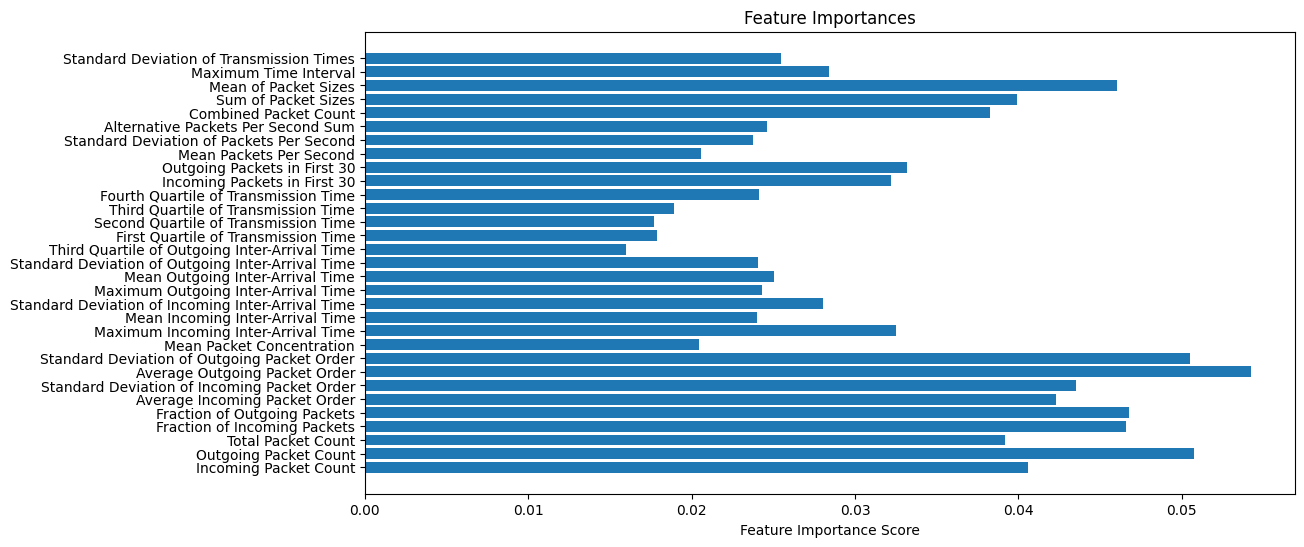

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_mon_features, y_mon, test_size=0.3, random_state=42)

# Initialize the Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
rf_clf.fit(X_train, y_train)

# Get feature importances
importances = rf_clf.feature_importances_

for i,v in enumerate(importances):
    print('Feature: %s, Score: %.5f' % (feature_names[i],v))

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(np.arange(len(feature_names)), feature_names)
plt.xlabel('Feature Importance Score')
plt.title('Feature Importances')
plt.show()

## Naive Bayes

Original number of features: 31, Reduced number of features: 8
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Accuracy: 0.1879
Best Params: {'var_smoothing': 6.579332246575683e-06}

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        62
           1       0.13      0.41      0.19        59
           2       0.25      0.05      0.09        55
           3       0.00      0.00      0.00        46
           4       0.00      0.00      0.00        53
           5       0.08      0.06      0.07        63
           6       0.28      0.28      0.28        65
           7       0.19      0.33      0.24        64
           8       0.41      0.15      0.22        59
           9       0.14      0.19      0.16        47
          10       0.42      0.08      0.13        66
          11       0.15      0.07      0.10        57
          12       0.52      0.22      0.31        59
          13       0.

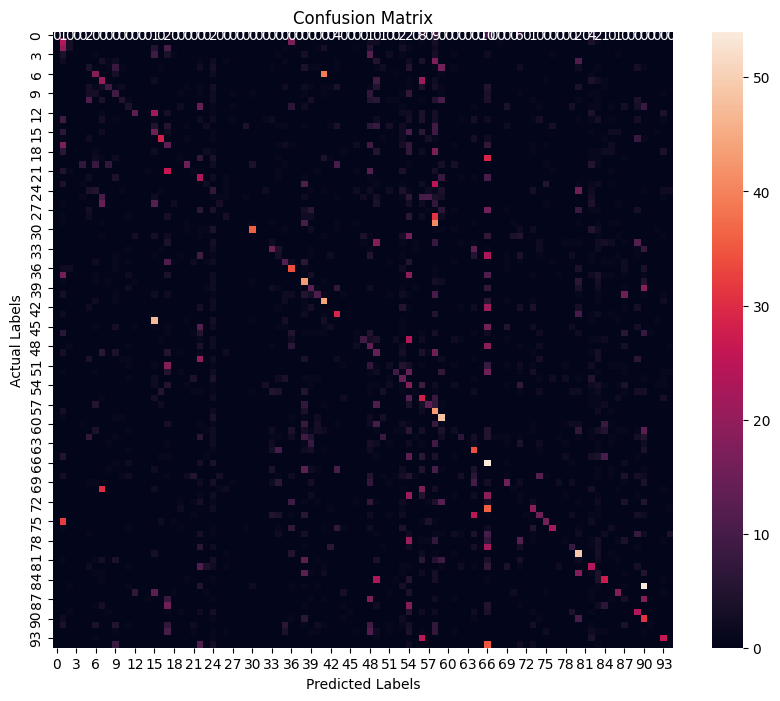

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Assuming X_categorical and y are your features and labels respectively
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_mon_features, y_mon, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
# Choose the number of components to explain a certain percentage of variance, e.g., 95%
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original number of features: {X_train_scaled.shape[1]}, Reduced number of features: {X_train_pca.shape[1]}")

# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Setting up the grid search
params = {
    'var_smoothing': np.logspace(0, -9, num=100)
}
grid_search = GridSearchCV(estimator=gnb, param_grid=params, cv=5, verbose=1, scoring='accuracy')

# Train the classifier with grid search
grid_search.fit(X_train_pca, y_train)

# Best estimator found by grid search
best_clf = grid_search.best_estimator_

# Make predictions with the best classifier
y_pred = best_clf.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(f'Best Params: {grid_search.best_params_}')

# Generate a classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

## SVM:

Accuracy: 0.6526

Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.45      0.47        62
           1       0.64      0.54      0.59        59
           2       0.59      0.75      0.66        55
           3       0.48      0.65      0.56        46
           4       0.58      0.75      0.66        53
           5       0.69      0.63      0.66        63
           6       0.73      0.85      0.79        65
           7       0.73      0.62      0.67        64
           8       0.73      0.64      0.68        59
           9       0.53      0.64      0.58        47
          10       0.75      0.70      0.72        66
          11       0.59      0.72      0.65        57
          12       0.82      0.80      0.81        59
          13       0.38      0.41      0.39        54
          14       0.54      0.53      0.54        58
          15       0.61      0.68      0.64        59
          16       0.67      0.62      

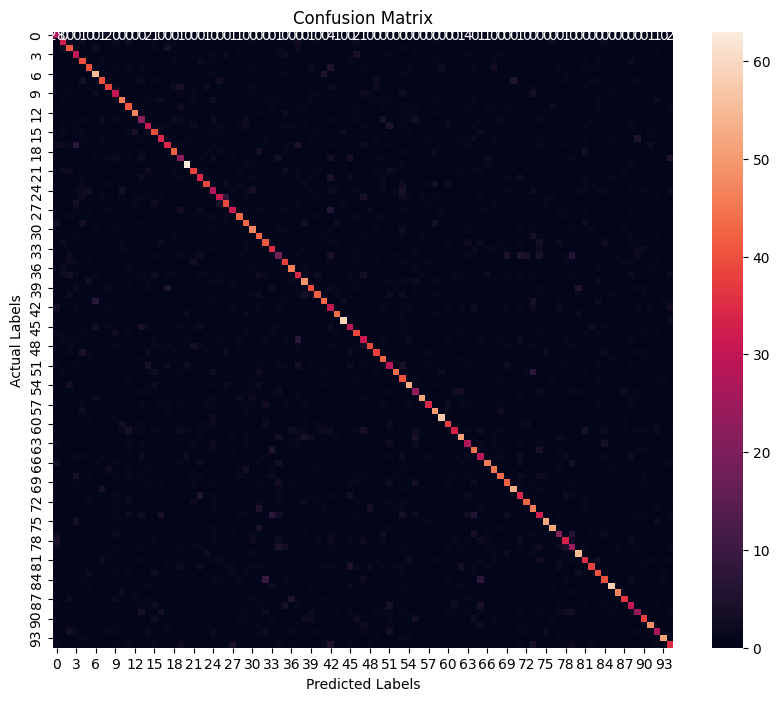

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_mon_features and y_mon are your features and labels respectively
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_mon_features, y_mon, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

svm_clf = SVC(kernel='rbf', C=1000, gamma=0.1)

# Train the classifier
svm_clf.fit(X_train_pca, y_train)

# Make predictions
y_pred = svm_clf.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Generate a classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

## Decision Tree:

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_categorical and y are your features and labels respectively
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_mon_features, y_mon, test_size=0.3, random_state=42)

# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Set up the grid of parameters to search
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV to find the best parameters
grid_search = GridSearchCV(dt_clf, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Train the classifier with best parameters
best_dt_clf = grid_search.best_estimator_

# Make predictions
y_pred = best_dt_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Generate a classification report
#print("\nClassification Report:\n")
#print(classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix
#conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
#plt.figure(figsize=(10, 8))
#sns.heatmap(conf_matrix, annot=True, fmt='g')
#plt.title('Confusion Matrix')
#plt.ylabel('Actual Labels')
#plt.xlabel('Predicted Labels')
#plt.show()

# Visualizing the Decision Tree
#plt.figure(figsize=(20, 10))
#plot_tree(best_dt_clf, filled=True, feature_names=feature_names, class_names=True)
#plt.title('Decision Tree')
#plt.show()

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.6354


## Random Forest Classifier:

Accuracy: 0.7846

Classification Report:

              precision    recall  f1-score   support

           0       0.75      0.68      0.71        62
           1       0.82      0.63      0.71        59
           2       0.88      0.95      0.91        55
           3       0.68      0.83      0.75        46
           4       0.81      0.89      0.85        53
           5       0.90      0.84      0.87        63
           6       0.83      0.92      0.88        65
           7       0.84      0.81      0.83        64
           8       0.83      0.81      0.82        59
           9       0.67      0.72      0.69        47
          10       0.85      0.71      0.78        66
          11       0.82      0.74      0.78        57
          12       0.89      0.92      0.90        59
          13       0.63      0.44      0.52        54
          14       0.79      0.59      0.67        58
          15       0.75      0.83      0.79        59
          16       0.80      0.71      

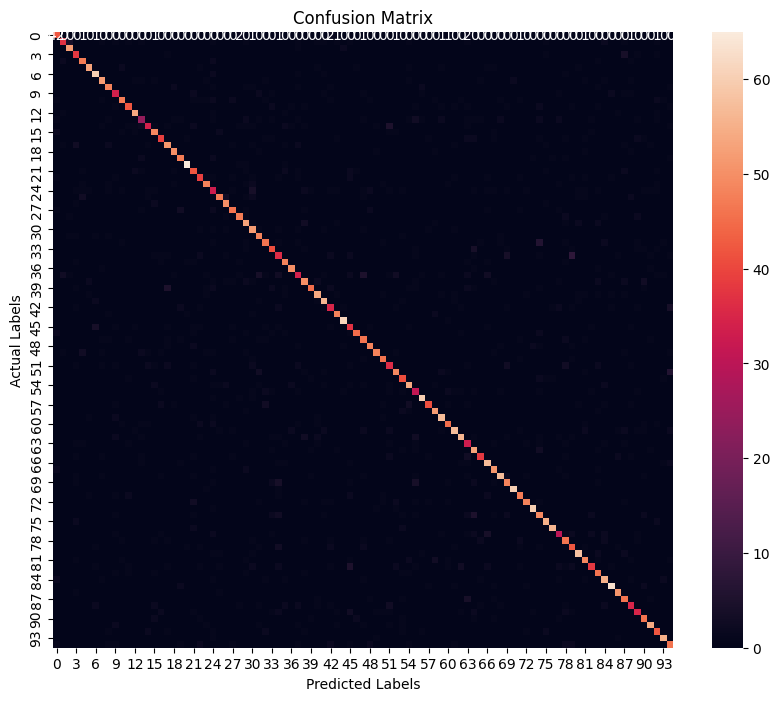

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_mon_features and y_mon are your features and labels respectively

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_mon_features, y_mon, test_size=0.3, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf = RandomForestClassifier(
    n_estimators=1000,
    criterion='entropy',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    n_jobs=-1
)

# Fit the classifier to the training data
clf.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Generate a classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

## k-NN Classifier:

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameter found:  {'n_neighbors': 3}
Accuracy: 0.5767

Classification Report:

              precision    recall  f1-score   support

           0       0.27      0.44      0.33        62
           1       0.50      0.58      0.54        59
           2       0.39      0.75      0.52        55
           3       0.33      0.65      0.43        46
           4       0.49      0.64      0.55        53
           5       0.47      0.65      0.55        63
           6       0.66      0.75      0.71        65
           7       0.47      0.53      0.50        64
           8       0.54      0.61      0.57        59
           9       0.36      0.57      0.45        47
          10       0.62      0.65      0.64        66
          11       0.46      0.68      0.55        57
          12       0.67      0.73      0.70        59
          13       0.29      0.43      0.35        54
          14       0.49      0.60      0.54  

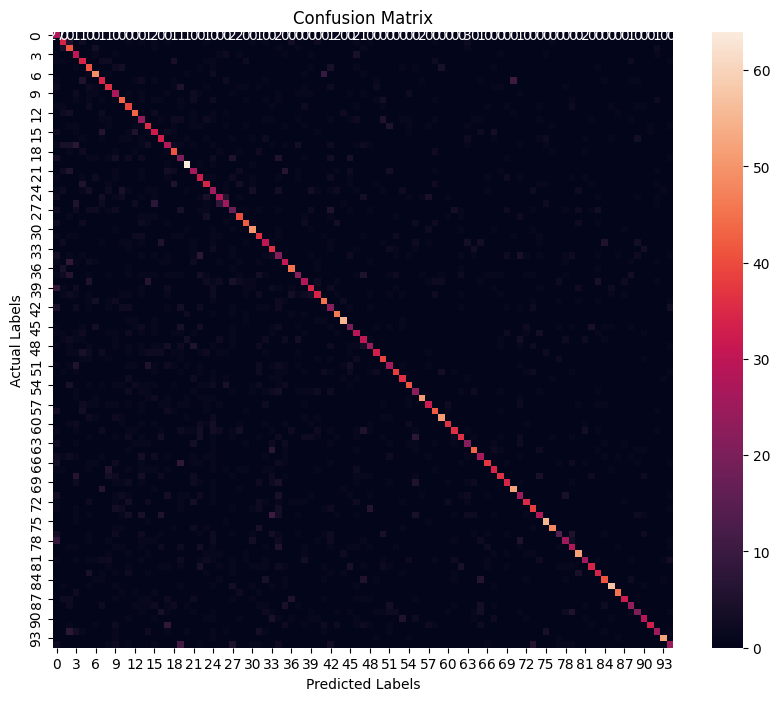

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_mon_features and y_mon are your features and labels respectively
X_train, X_test, y_train, y_test = train_test_split(X_mon_features, y_mon, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Initialize the k-NN Classifier
knn_clf = KNeighborsClassifier()

# Set up the grid of parameters to search
param_grid = {'n_neighbors': [3, 5, 7, 9, 11,]}

# Set up GridSearchCV with k-NN
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_pca, y_train)

# Best parameter found
print("Best parameter found: ", grid_search.best_params_)

# Train the classifier with the best number of neighbors
best_knn_clf = grid_search.best_estimator_
y_pred = best_knn_clf.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Generate a classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

## DB-Scan:

Accuracy of DBSCAN clustering: 0.2214
[[  0   0   0 ...   8   0  77]
 [  0  38  20 ...   0   0 120]
 [  0   0  47 ...   0   0  66]
 ...
 [  0   0   0 ... 147   0  53]
 [  0   0   0 ...   1   5  77]
 [  0   0   0 ...   0   0   0]]


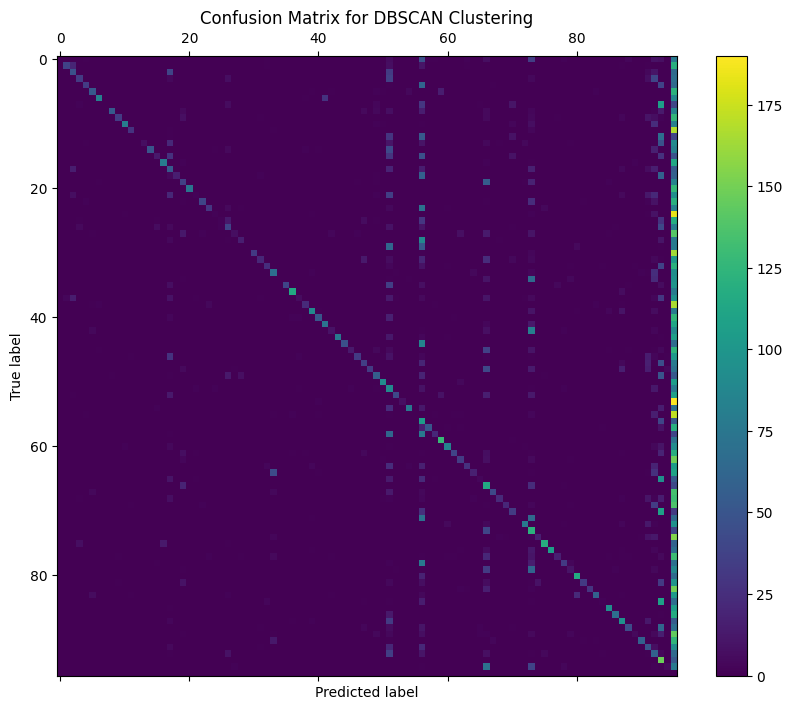

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import mode
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Feature Scaling is important for both PCA and DBSCAN
X_scaled = StandardScaler().fit_transform(X_mon_features)

# Apply PCA
pca = PCA(n_components=0.95)  # Adjust n_components as needed
X_pca = pca.fit_transform(X_scaled)

# DBSCAN Clustering on PCA-transformed data
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_pca)

# Create a label for each cluster based on the mode of the true labels in that cluster
labels_pred = np.zeros_like(clusters)
for cluster in np.unique(clusters):
    if cluster != -1:  # Ignore noise points
        mask = (clusters == cluster)
        labels_pred[mask] = mode(y_mon[mask])[0]

# Assign a unique label for noise points
noise_label = max(y_mon) + 1
labels_pred[clusters == -1] = noise_label

# Compute the accuracy of DBSCAN
accuracy = accuracy_score(y_mon, labels_pred)
print(f'Accuracy of DBSCAN clustering: {accuracy:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_mon, labels_pred)
print(conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
plt.matshow(conf_matrix, cmap='viridis', fignum=1)
plt.title('Confusion Matrix for DBSCAN Clustering')
plt.colorbar()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## k-Means:

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Accuracy of KMeans clustering: 0.2420
[[ 13   0   0 ...   0   1   0]
 [  0  79   0 ...   0   1   0]
 [  0  36   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0 114   0]
 [  0   0   0 ...   0   0   0]]


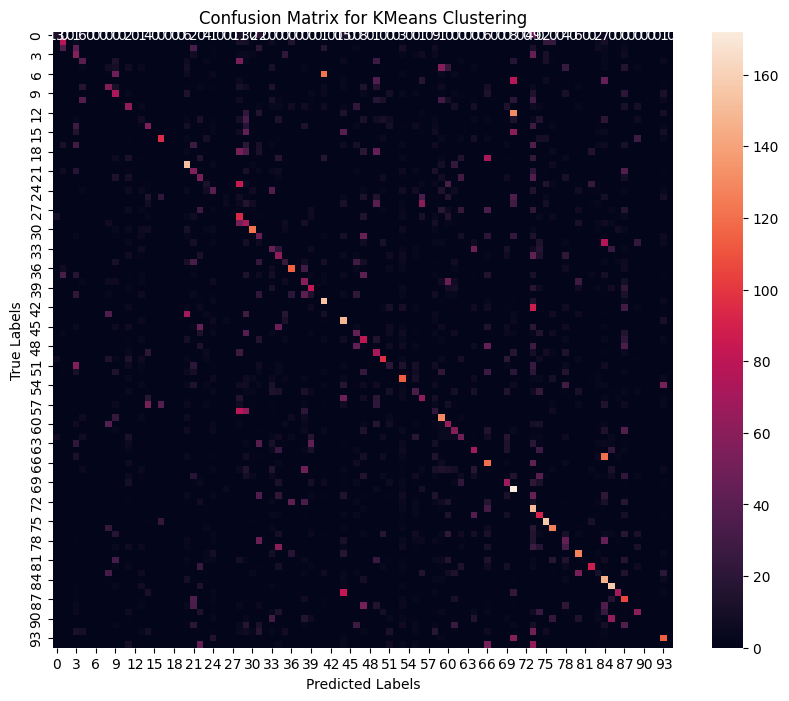

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_mon_features and y_mon are your features and labels respectively

# Determine the number of unique labels which will be our number of clusters for KMeans
n_clusters = len(np.unique(y_mon))

# Feature Scaling
X_scaled = StandardScaler().fit_transform(X_mon_features)

# Apply PCA
pca = PCA(n_components=0.975)  # Keep 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# KMeans Clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Assign the most frequent true label to each cluster
labels_pred = np.zeros_like(clusters)
for cluster in np.unique(clusters):
    mask = (clusters == cluster)
    # Find the most frequent label in each cluster
    labels_pred[mask] = mode(y_mon[mask])[0]

# Compute the accuracy of KMeans
accuracy = accuracy_score(y_mon, labels_pred)
print(f'Accuracy of KMeans clustering: {accuracy:.4f}')

# Compute a confusion matrix
conf_matrix = confusion_matrix(y_mon, labels_pred)
print(conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix for KMeans Clustering')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

## Neuronal Network:

Epoch 1/150
241/241 [==============================] - 6s 16ms/step - loss: 3.5685 - accuracy: 0.1665 - val_loss: 2.8689 - val_accuracy: 0.3211
Epoch 2/150
241/241 [==============================] - 4s 15ms/step - loss: 2.8480 - accuracy: 0.2820 - val_loss: 2.3767 - val_accuracy: 0.4094
Epoch 3/150
241/241 [==============================] - 4s 15ms/step - loss: 2.5557 - accuracy: 0.3432 - val_loss: 2.1123 - val_accuracy: 0.4649
Epoch 4/150
241/241 [==============================] - 4s 15ms/step - loss: 2.3688 - accuracy: 0.3801 - val_loss: 1.9319 - val_accuracy: 0.4977
Epoch 5/150
241/241 [==============================] - 4s 15ms/step - loss: 2.2219 - accuracy: 0.4109 - val_loss: 1.8269 - val_accuracy: 0.5316
Epoch 6/150
241/241 [==============================] - 4s 15ms/step - loss: 2.0978 - accuracy: 0.4420 - val_loss: 1.6976 - val_accuracy: 0.5643
Epoch 7/150
241/241 [==============================] - 4s 15ms/step - loss: 2.0031 - accuracy: 0.4661 - val_loss: 1.5915 - val_accuracy:

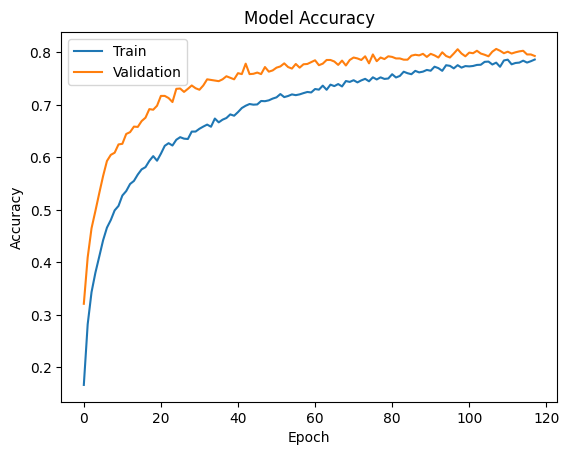

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.constraints import MaxNorm

# Assuming X_mon_features and y are your features and labels respectively

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_mon_features)

# Convert labels to categorical (one-hot encoding)
y_categorical = to_categorical(y_mon)

# Split the data into training and testing sets, with shuffling
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.1, shuffle=True, random_state=42)

# Lower the dropout rate to reduce generalization
dropout_rate = 0.3  # Lowered dropout rate

# Define the optimizer with a modified learning rate schedule
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule)

# Add MaxNorm weight constraint
weight_constraint = MaxNorm(max_value=4, axis=0)

# Define the model with different architecture and complexity
model = Sequential([
    Dense(1024, input_dim=X_train.shape[1], kernel_constraint=weight_constraint),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(dropout_rate),
    Dense(768, kernel_constraint=weight_constraint),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(dropout_rate),
    Dense(512, kernel_constraint=weight_constraint),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(dropout_rate),
    Dense(256, kernel_constraint=weight_constraint),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(dropout_rate),
    Dense(y_categorical.shape[1], activation='softmax')
])

# Compile the model with the adjusted optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback with decreased patience to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model with an adjusted batch size and validation split
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=64,  # Adjusted batch size
    validation_split=0.1,  # Slightly reduced validation split
    verbose=1,
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Open World:

## Data Preparation:

In [ ]:
import numpy as np


# Create labels for monitored data
y_mon_ones = np.ones(len(X1_mon))

# Create labels for unmonitored data, filled with 95
y_unmon_ninety_fives = np.full(len(X1_unmon), 95)

# Combine the datasets
X1_combined = np.concatenate((X1_mon, X1_unmon), axis=0)
X2_combined = np.concatenate((X2_mon, X2_unmon), axis=0)

# Combine the labels
y_unmon_binary = np.concatenate((y_mon_ones, y_unmon_ninety_fives), axis=0)
y_unmon = np.concatenate((y_mon, y_unmon_ninety_fives), axis=0)


In [ ]:
import numpy as np
import statistics

# Packet Direction and Size Analysis
incoming_packet_count = [sum(1 for size in sub_array if size < 0) for sub_array in X2_combined]  # Incoming Packet Count
outgoing_packet_count = [sum(1 for size in sub_array if size > 0) for sub_array in X2_combined]  # Outgoing Packet Count
total_packet_count = [len(sub_array) for sub_array in X2_combined]  # Total Packet Count
fraction_incoming_packets = [incoming / len(sub_array) if len(sub_array) != 0 else 0 for incoming, sub_array in zip(incoming_packet_count, X2_combined)]  # Fraction of Incoming Packets
fraction_outgoing_packets = [outgoing / len(sub_array) if len(sub_array) != 0 else 0 for outgoing, sub_array in zip(outgoing_packet_count, X2_combined)]  # Fraction of Outgoing Packets

# Packet Ordering Statistics
avg_incoming_packet_order = [np.mean([i for i, size in enumerate(sub_array) if size < 0]) if any(size < 0 for size in sub_array) else 0 for sub_array in X2_combined]  # Avg. Incoming Packet Order
std_dev_incoming_packet_order = [np.std([i for i, size in enumerate(sub_array) if size < 0]) if any(size < 0 for size in sub_array) else 0 for sub_array in X2_combined]  # Std. Dev. Incoming Packet Order
avg_outgoing_packet_order = [np.mean([i for i, size in enumerate(sub_array) if size > 0]) if any(size > 0 for size in sub_array) else 0 for sub_array in X2_combined]  # Avg. Outgoing Packet Order
std_dev_outgoing_packet_order = [np.std([i for i, size in enumerate(sub_array) if size > 0]) if any(size > 0 for size in sub_array) else 0 for sub_array in X2_combined]  # Std. Dev. Outgoing Packet Order

# Packet Concentration and Inter-Arrival Times
packet_concentration = [np.mean(np.diff(time_seq)) if len(time_seq) > 1 else 0 for time_seq in X1_combined]  # Mean Packet Concentration
incoming_inter_arrival_stats = []
outgoing_inter_arrival_stats = []
for time_seq, size_seq in zip(X1_combined, X2_combined):
    if len(time_seq) > 1:
        incoming_times = [time for time, size in zip(time_seq, size_seq) if size < 0]
        outgoing_times = [time for time, size in zip(time_seq, size_seq) if size > 0]
        if incoming_times:
            incoming_diffs = np.diff(incoming_times)
            incoming_inter_arrival_stats.append([np.max(incoming_diffs), np.mean(incoming_diffs), np.std(incoming_diffs), np.percentile(incoming_diffs, 75)])
        else:
            incoming_inter_arrival_stats.append([0, 0, 0, 0])
        if outgoing_times:
            outgoing_diffs = np.diff(outgoing_times)
            outgoing_inter_arrival_stats.append([np.max(outgoing_diffs), np.mean(outgoing_diffs), np.std(outgoing_diffs), np.percentile(outgoing_diffs, 75)])
        else:
            outgoing_inter_arrival_stats.append([0, 0, 0, 0])
    else:
        incoming_inter_arrival_stats.append([0, 0, 0, 0])
        outgoing_inter_arrival_stats.append([0, 0, 0, 0])
incoming_max_inter_arrival_time, incoming_mean_inter_arrival_time, incoming_std_inter_arrival_time, incoming_third_quartile_inter_arrival_time = zip(*incoming_inter_arrival_stats)
outgoing_max_inter_arrival_time, outgoing_mean_inter_arrival_time, outgoing_std_inter_arrival_time, outgoing_third_quartile_inter_arrival_time = zip(*outgoing_inter_arrival_stats)

# Transmission Time Analysis
transmission_time_stats = [[np.percentile(time_seq, q) for q in [25, 50, 75, 100]] for time_seq in X1_combined]  # Quartiles of Transmission Times
transmission_time_Q1, transmission_time_Q2, transmission_time_Q3, transmission_time_Q4 = zip(*transmission_time_stats)

# Packet Count in First 30
incoming_packets_first30 = [sum(1 for size in sub_array[:30] if size < 0) for sub_array in X2_combined]  # Incoming Packets in First 30
outgoing_packets_first30 = [sum(1 for size in sub_array[:30] if size > 0) for sub_array in X2_combined]  # Outgoing Packets in First 30

# Packet Per Second Analysis
packets_per_second_stats = [[np.mean(np.diff(time_seq)), np.std(np.diff(time_seq)), np.median(np.diff(time_seq))] if len(time_seq) > 1 else [0, 0, 0] for time_seq in X1_combined]
mean_packets_per_second, std_packets_per_second, median_packets_per_second = zip(*packets_per_second_stats)

# Alternative Packets Per Second Sum
alternative_packets_per_second_sum = [sum(np.diff(time_seq)) for time_seq in X1_combined]  # Alternative Packets Per Second Sum
combined_counts = [incoming + outgoing + total for incoming, outgoing, total in zip(incoming_packet_count, outgoing_packet_count, total_packet_count)]

# Additional Features
sum_packet_sizes = [sum(abs(size) for size in sub_array) for sub_array in X2_combined]  # Sum of Packet Sizes
mean_sequence_value = [np.mean(sub_array) for sub_array in X2_combined]  # Mean of the Sequence

max_packet_size = [max(sub_array, default=0) for sub_array in X2_combined]  # Max Packet Size for each time series

average_packet_size = [np.mean([abs(size) for size in sub_array]) if sub_array else 0 for sub_array in X2_combined]  # Average Packet Size for each time series
peak_to_average_packet_ratio = [max_size / avg_size if avg_size != 0 else 0 for max_size, avg_size in zip(max_packet_size, average_packet_size)]  # Peak to Average Packet Ratio for each time series

max_time_interval = [max(np.diff(time_seq), default=0) for time_seq in X1_combined]  # Max Time Interval for each time series

std_dev_transmission_times = [np.std(np.diff(time_seq)) if len(time_seq) > 1 else 0 for time_seq in X1_combined]

small_packet_threshold = 513  # Define the threshold for small packets
percentage_small_packets = [sum(1 for size in sub_array if abs(size) < small_packet_threshold) / len(sub_array) * 100 if sub_array else 0 for sub_array in X2_combined]  # Percentage of Small Packets for each time series

In [ ]:
feature_names = [
    "Incoming Packet Count",
    "Outgoing Packet Count",
    "Total Packet Count",
    "Fraction of Incoming Packets",
    "Fraction of Outgoing Packets",
    "Average Incoming Packet Order",
    "Standard Deviation of Incoming Packet Order",
    "Average Outgoing Packet Order",
    "Standard Deviation of Outgoing Packet Order",
    "Mean Packet Concentration",
    "Maximum Incoming Inter-Arrival Time",
    "Mean Incoming Inter-Arrival Time",
    "Standard Deviation of Incoming Inter-Arrival Time",
    #"Third Quartile of Incoming Inter-Arrival Time",
    "Maximum Outgoing Inter-Arrival Time",
    "Mean Outgoing Inter-Arrival Time",
    "Standard Deviation of Outgoing Inter-Arrival Time",
    "Third Quartile of Outgoing Inter-Arrival Time",
    "First Quartile of Transmission Time",
    "Second Quartile of Transmission Time",
    "Third Quartile of Transmission Time",
    "Fourth Quartile of Transmission Time",
    "Incoming Packets in First 30",
    "Outgoing Packets in First 30",
    "Mean Packets Per Second",
    "Standard Deviation of Packets Per Second",
    #"Median Packets Per Second",
    "Alternative Packets Per Second Sum",
    "Combined Packet Count",
    "Sum of Packet Sizes",
    "Mean of Packet Sizes",
    #"Maximum Packet Size",
    #"Peak to Average Packet Size Ratio",
    "Maximum Time Interval",
    "Standard Deviation of Transmission Times",
    #"Percentage of Small Packets"
]

X_unmon_features = np.column_stack((
    incoming_packet_count,
    outgoing_packet_count,
    total_packet_count,
    fraction_incoming_packets,
    fraction_outgoing_packets,
    avg_incoming_packet_order,
    std_dev_incoming_packet_order,
    avg_outgoing_packet_order,
    std_dev_outgoing_packet_order,
    packet_concentration,
    incoming_max_inter_arrival_time,
    incoming_mean_inter_arrival_time,
    incoming_std_inter_arrival_time,
    #incoming_third_quartile_inter_arrival_time,
    outgoing_max_inter_arrival_time,
    outgoing_mean_inter_arrival_time,
    outgoing_std_inter_arrival_time,
    outgoing_third_quartile_inter_arrival_time,
    transmission_time_Q1,
    transmission_time_Q2,
    transmission_time_Q3,
    transmission_time_Q4,
    incoming_packets_first30,
    outgoing_packets_first30,
    mean_packets_per_second,
    std_packets_per_second,
    #median_packets_per_second,
    alternative_packets_per_second_sum,
    combined_counts,
    sum_packet_sizes,
    mean_sequence_value,
    #max_packet_size,
    #peak_to_average_packet_ratio,
    max_time_interval,
    std_dev_transmission_times,
    #percentage_small_packets
))

In [ ]:
import numpy as np


# Create labels for monitored data
y_mon_ones = np.ones(len(X1_mon))

# Create labels for unmonitored data, filled with 95
y_unmon_ninety_fives = np.full(len(X1_unmon), 95)

# Combine the datasets
X1_combined = np.concatenate((X1_mon, X1_unmon), axis=0)
X2_combined = np.concatenate((X2_mon, X2_unmon), axis=0)

# Combine the labels
y_unmon_binary = np.concatenate((y_mon_ones, y_unmon_ninety_fives), axis=0)
y_unmon = np.concatenate((y_mon, y_unmon_ninety_fives), axis=0)


In [6]:
import numpy as np
import statistics

# Packet Direction and Size Analysis
incoming_packet_count = [sum(1 for size in sub_array if size < 0) for sub_array in X2_combined]  # Incoming Packet Count
outgoing_packet_count = [sum(1 for size in sub_array if size > 0) for sub_array in X2_combined]  # Outgoing Packet Count
total_packet_count = [len(sub_array) for sub_array in X2_combined]  # Total Packet Count
fraction_incoming_packets = [incoming / len(sub_array) if len(sub_array) != 0 else 0 for incoming, sub_array in zip(incoming_packet_count, X2_combined)]  # Fraction of Incoming Packets
fraction_outgoing_packets = [outgoing / len(sub_array) if len(sub_array) != 0 else 0 for outgoing, sub_array in zip(outgoing_packet_count, X2_combined)]  # Fraction of Outgoing Packets

# Packet Ordering Statistics
avg_incoming_packet_order = [np.mean([i for i, size in enumerate(sub_array) if size < 0]) if any(size < 0 for size in sub_array) else 0 for sub_array in X2_combined]  # Avg. Incoming Packet Order
std_dev_incoming_packet_order = [np.std([i for i, size in enumerate(sub_array) if size < 0]) if any(size < 0 for size in sub_array) else 0 for sub_array in X2_combined]  # Std. Dev. Incoming Packet Order
avg_outgoing_packet_order = [np.mean([i for i, size in enumerate(sub_array) if size > 0]) if any(size > 0 for size in sub_array) else 0 for sub_array in X2_combined]  # Avg. Outgoing Packet Order
std_dev_outgoing_packet_order = [np.std([i for i, size in enumerate(sub_array) if size > 0]) if any(size > 0 for size in sub_array) else 0 for sub_array in X2_combined]  # Std. Dev. Outgoing Packet Order

# Packet Concentration and Inter-Arrival Times
packet_concentration = [np.mean(np.diff(time_seq)) if len(time_seq) > 1 else 0 for time_seq in X1_combined]  # Mean Packet Concentration
incoming_inter_arrival_stats = []
outgoing_inter_arrival_stats = []
for time_seq, size_seq in zip(X1_combined, X2_combined):
    if len(time_seq) > 1:
        incoming_times = [time for time, size in zip(time_seq, size_seq) if size < 0]
        outgoing_times = [time for time, size in zip(time_seq, size_seq) if size > 0]
        if incoming_times:
            incoming_diffs = np.diff(incoming_times)
            incoming_inter_arrival_stats.append([np.max(incoming_diffs), np.mean(incoming_diffs), np.std(incoming_diffs), np.percentile(incoming_diffs, 75)])
        else:
            incoming_inter_arrival_stats.append([0, 0, 0, 0])
        if outgoing_times:
            outgoing_diffs = np.diff(outgoing_times)
            outgoing_inter_arrival_stats.append([np.max(outgoing_diffs), np.mean(outgoing_diffs), np.std(outgoing_diffs), np.percentile(outgoing_diffs, 75)])
        else:
            outgoing_inter_arrival_stats.append([0, 0, 0, 0])
    else:
        incoming_inter_arrival_stats.append([0, 0, 0, 0])
        outgoing_inter_arrival_stats.append([0, 0, 0, 0])
incoming_max_inter_arrival_time, incoming_mean_inter_arrival_time, incoming_std_inter_arrival_time, incoming_third_quartile_inter_arrival_time = zip(*incoming_inter_arrival_stats)
outgoing_max_inter_arrival_time, outgoing_mean_inter_arrival_time, outgoing_std_inter_arrival_time, outgoing_third_quartile_inter_arrival_time = zip(*outgoing_inter_arrival_stats)

# Transmission Time Analysis
transmission_time_stats = [[np.percentile(time_seq, q) for q in [25, 50, 75, 100]] for time_seq in X1_combined]  # Quartiles of Transmission Times
transmission_time_Q1, transmission_time_Q2, transmission_time_Q3, transmission_time_Q4 = zip(*transmission_time_stats)

# Packet Count in First 30
incoming_packets_first30 = [sum(1 for size in sub_array[:30] if size < 0) for sub_array in X2_combined]  # Incoming Packets in First 30
outgoing_packets_first30 = [sum(1 for size in sub_array[:30] if size > 0) for sub_array in X2_combined]  # Outgoing Packets in First 30

# Packet Per Second Analysis
packets_per_second_stats = [[np.mean(np.diff(time_seq)), np.std(np.diff(time_seq)), np.median(np.diff(time_seq))] if len(time_seq) > 1 else [0, 0, 0] for time_seq in X1_combined]
mean_packets_per_second, std_packets_per_second, median_packets_per_second = zip(*packets_per_second_stats)

# Alternative Packets Per Second Sum
alternative_packets_per_second_sum = [sum(np.diff(time_seq)) for time_seq in X1_combined]  # Alternative Packets Per Second Sum
combined_counts = [incoming + outgoing + total for incoming, outgoing, total in zip(incoming_packet_count, outgoing_packet_count, total_packet_count)]

# Additional Features
sum_packet_sizes = [sum(abs(size) for size in sub_array) for sub_array in X2_combined]  # Sum of Packet Sizes
mean_sequence_value = [np.mean(sub_array) for sub_array in X2_combined]  # Mean of the Sequence

max_packet_size = [max(sub_array, default=0) for sub_array in X2_combined]  # Max Packet Size for each time series

average_packet_size = [np.mean([abs(size) for size in sub_array]) if sub_array else 0 for sub_array in X2_combined]  # Average Packet Size for each time series
peak_to_average_packet_ratio = [max_size / avg_size if avg_size != 0 else 0 for max_size, avg_size in zip(max_packet_size, average_packet_size)]  # Peak to Average Packet Ratio for each time series

max_time_interval = [max(np.diff(time_seq), default=0) for time_seq in X1_combined]  # Max Time Interval for each time series

std_dev_transmission_times = [np.std(np.diff(time_seq)) if len(time_seq) > 1 else 0 for time_seq in X1_combined]

small_packet_threshold = 513  # Define the threshold for small packets
percentage_small_packets = [sum(1 for size in sub_array if abs(size) < small_packet_threshold) / len(sub_array) * 100 if sub_array else 0 for sub_array in X2_combined]  # Percentage of Small Packets for each time series

NameError: name 'X2_combined' is not defined

In [ ]:
feature_names = [
    "Incoming Packet Count",
    "Outgoing Packet Count",
    "Total Packet Count",
    "Fraction of Incoming Packets",
    "Fraction of Outgoing Packets",
    "Average Incoming Packet Order",
    "Standard Deviation of Incoming Packet Order",
    "Average Outgoing Packet Order",
    "Standard Deviation of Outgoing Packet Order",
    "Mean Packet Concentration",
    "Maximum Incoming Inter-Arrival Time",
    "Mean Incoming Inter-Arrival Time",
    "Standard Deviation of Incoming Inter-Arrival Time",
    #"Third Quartile of Incoming Inter-Arrival Time",
    "Maximum Outgoing Inter-Arrival Time",
    "Mean Outgoing Inter-Arrival Time",
    "Standard Deviation of Outgoing Inter-Arrival Time",
    "Third Quartile of Outgoing Inter-Arrival Time",
    "First Quartile of Transmission Time",
    "Second Quartile of Transmission Time",
    "Third Quartile of Transmission Time",
    "Fourth Quartile of Transmission Time",
    "Incoming Packets in First 30",
    "Outgoing Packets in First 30",
    "Mean Packets Per Second",
    "Standard Deviation of Packets Per Second",
    #"Median Packets Per Second",
    "Alternative Packets Per Second Sum",
    "Combined Packet Count",
    "Sum of Packet Sizes",
    "Mean of Packet Sizes",
    #"Maximum Packet Size",
    #"Peak to Average Packet Size Ratio",
    "Maximum Time Interval",
    "Standard Deviation of Transmission Times",
    #"Percentage of Small Packets"
]

X_unmon_features = np.column_stack((
    incoming_packet_count,
    outgoing_packet_count,
    total_packet_count,
    fraction_incoming_packets,
    fraction_outgoing_packets,
    avg_incoming_packet_order,
    std_dev_incoming_packet_order,
    avg_outgoing_packet_order,
    std_dev_outgoing_packet_order,
    packet_concentration,
    incoming_max_inter_arrival_time,
    incoming_mean_inter_arrival_time,
    incoming_std_inter_arrival_time,
    #incoming_third_quartile_inter_arrival_time,
    outgoing_max_inter_arrival_time,
    outgoing_mean_inter_arrival_time,
    outgoing_std_inter_arrival_time,
    outgoing_third_quartile_inter_arrival_time,
    transmission_time_Q1,
    transmission_time_Q2,
    transmission_time_Q3,
    transmission_time_Q4,
    incoming_packets_first30,
    outgoing_packets_first30,
    mean_packets_per_second,
    std_packets_per_second,
    #median_packets_per_second,
    alternative_packets_per_second_sum,
    combined_counts,
    sum_packet_sizes,
    mean_sequence_value,
    #max_packet_size,
    #peak_to_average_packet_ratio,
    max_time_interval,
    std_dev_transmission_times,
    #percentage_small_packets
))

## Open World Multi Class:

### Naive Bayes

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:14

Accuracy: 0.3093
ROC AUC: 0.8489
Precision: 0.2748
Recall: 0.3093
F1-Score: 0.2690

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        51
           1       0.14      0.25      0.18        65
           2       0.00      0.00      0.00        56
           3       0.00      0.00      0.00        58
           4       0.00      0.00      0.00        52
           5       0.11      0.04      0.05        56
           6       0.33      0.23      0.27        62
           7       0.13      0.27      0.18        63
           8       0.21      0.07      0.11        55
           9       0.10      0.06      0.07        51
          10       0.75      0.05      0.10        56
          11       0.00      0.00      0.00        70
          12       0.00      0.00      0.00        63
          13       0.00      0.00      0.00        64
          14       0.00      0.00      0.00        69
          15       0.09    

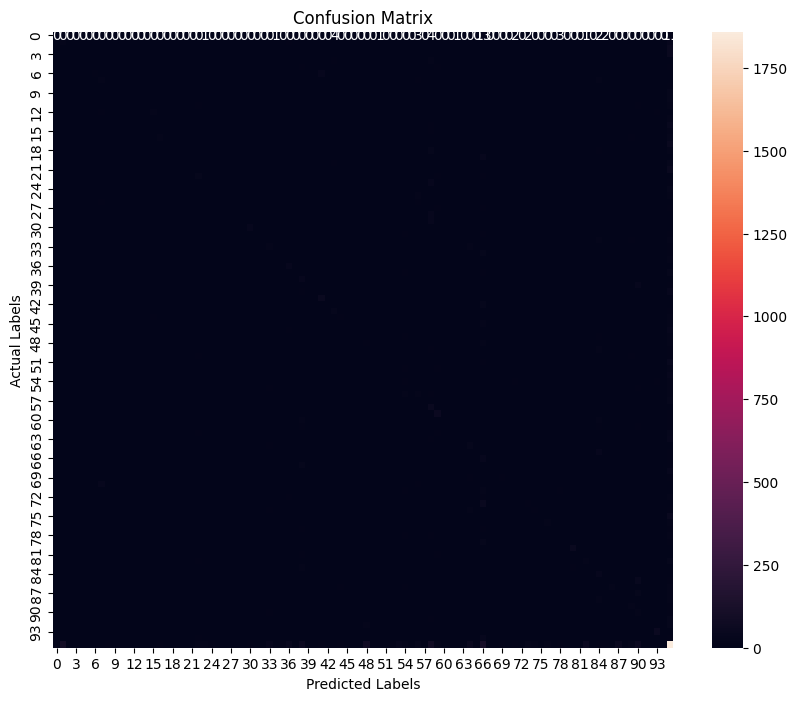

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_unmon_features, y_unmon, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Initialize the Gaussian Naive Bayes classifier
gnb = GaussianNB()
gnb.fit(X_train_pca, y_train)

# Make predictions
y_pred = gnb.predict(X_test_pca)
y_pred_probs = gnb.predict_proba(X_test_pca)

# Calculate accuracy and other performance metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')  # Use 'ovo' for One-vs-One
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

### SVM:

Accuracy: 0.6486
ROC AUC: 0.9682
Precision: 0.6424
Recall: 0.6486
F1-Score: 0.6422

Classification Report:

              precision    recall  f1-score   support

           0       0.47      0.37      0.42        51
           1       0.46      0.42      0.44        65
           2       0.61      0.62      0.62        56
           3       0.60      0.41      0.49        58
           4       0.68      0.69      0.69        52
           5       0.64      0.70      0.67        56
           6       0.67      0.81      0.73        62
           7       0.61      0.56      0.58        63
           8       0.66      0.60      0.63        55
           9       0.59      0.43      0.50        51
          10       0.57      0.62      0.60        56
          11       0.59      0.53      0.56        70
          12       0.68      0.83      0.75        63
          13       0.42      0.28      0.34        64
          14       0.55      0.52      0.53        69
          15       0.54    

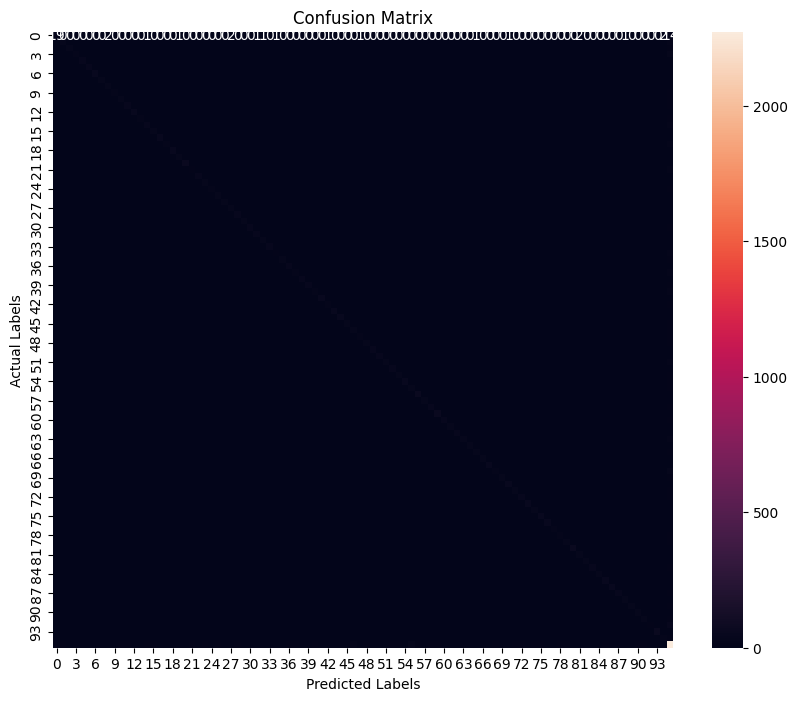

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_unmon_features and y_unmon are your features and labels respectively
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_unmon_features, y_unmon, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Initialize the Support Vector Classifier
svm_clf = SVC(C=1000, kernel='rbf', gamma=0.1, probability=True)

# Train the classifier on the transformed data
svm_clf.fit(X_train_pca, y_train)

# Make predictions on the transformed test data
y_pred = svm_clf.predict(X_test_pca)
y_pred_probs = svm_clf.predict_proba(X_test_pca)

# Calculate accuracy and other performance metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Output the results
print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Generate and print a classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

### Decision Tree:

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.5843
Precision: 0.5834
Recall: 0.5843
F1-Score: 0.5802

Classification Report:

              precision    recall  f1-score   support

           0       0.37      0.37      0.37        51
           1       0.34      0.40      0.37        65
           2       0.46      0.50      0.48        56
           3       0.33      0.29      0.31        58
           4       0.61      0.58      0.59        52
           5       0.51      0.62      0.56        56
           6       0.72      0.77      0.74        62
           7       0.70      0.62      0.66        63
           8       0.45      0.62      0.52        55
           9       0.46      0.35      0.40        51
          10       0.34      0.41      0.37        56
          11       0.57      0.47      0.52        70
          12       0.68      0.68      0.68        63


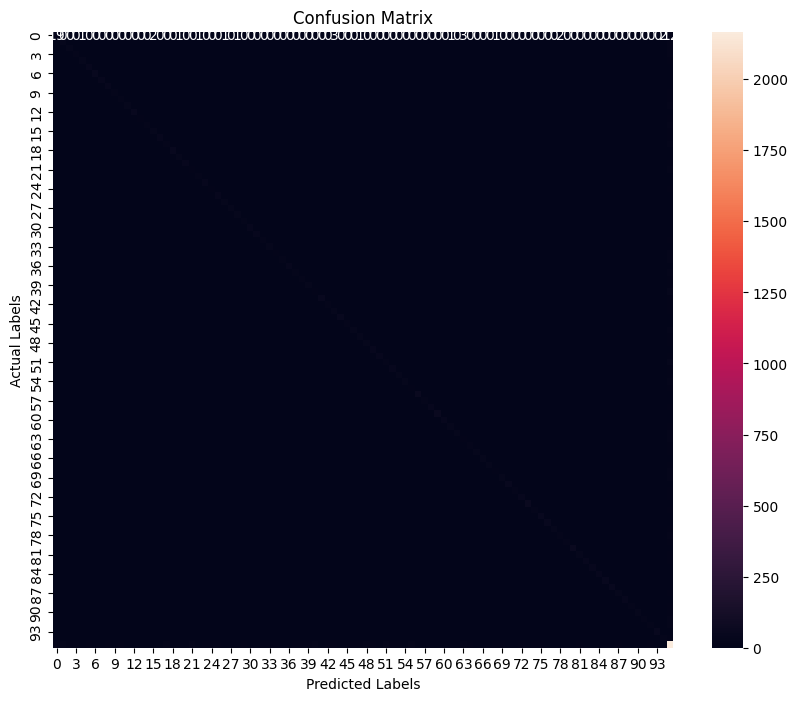

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale the features
X_scaled = scaler.fit_transform(X_unmon_features)

# Splitting the scaled dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_unmon, test_size=0.3, random_state=42)

# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Set up the grid of parameters to search
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV to find the best parameters
grid_search = GridSearchCV(dt_clf, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Train the classifier with best parameters
best_dt_clf = grid_search.best_estimator_

# Make predictions
y_pred = best_dt_clf.predict(X_test)

# Calculate accuracy and other performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Generate and print a classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Optional: Visualizing the Decision Tree
# plt.figure(figsize=(20, 10))
# plot_tree(best_dt_clf, filled=True, feature_names=feature_names, class_names=True)
# plt.title('Decision Tree')
# plt.show()

### Random Forest Classifier:

Accuracy: 0.7579
ROC AUC: 0.9792
Precision: 0.7747
Recall: 0.7579
F1-Score: 0.7493

Classification Report:

              precision    recall  f1-score   support

           0       0.69      0.49      0.57        51
           1       0.78      0.48      0.59        65
           2       0.91      0.86      0.88        56
           3       0.86      0.53      0.66        58
           4       0.80      0.75      0.77        52
           5       0.84      0.75      0.79        56
           6       0.85      0.94      0.89        62
           7       0.71      0.79      0.75        63
           8       0.91      0.75      0.82        55
           9       0.87      0.53      0.66        51
          10       0.90      0.64      0.75        56
          11       0.86      0.53      0.65        70
          12       0.79      0.90      0.84        63
          13       0.76      0.39      0.52        64
          14       0.90      0.52      0.66        69
          15       0.80    

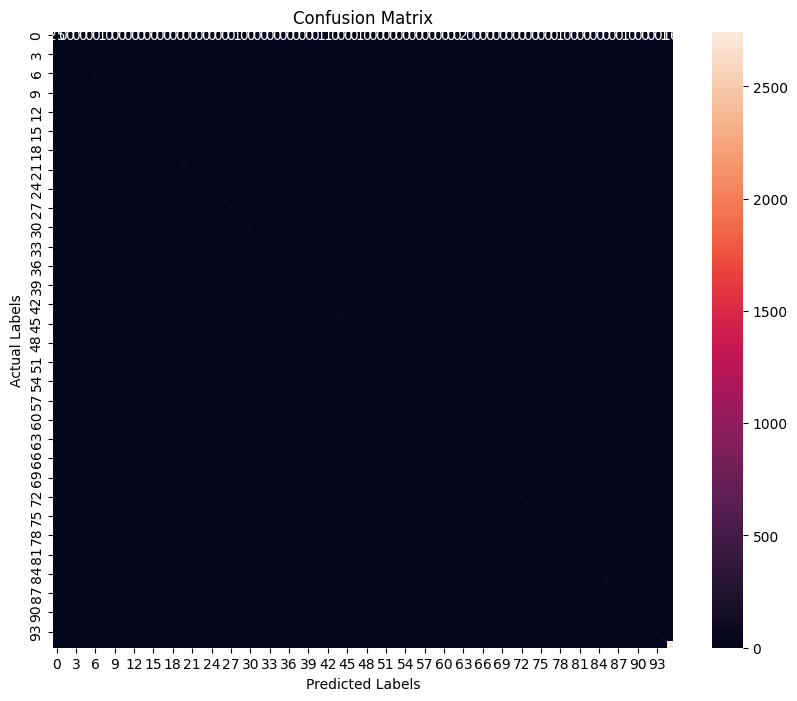

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_unmon_features, y_unmon, test_size=0.3, random_state=42)

# Initialize the scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the RandomForestClassifier
clf = RandomForestClassifier(
    n_estimators=1000,
    criterion='entropy',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    bootstrap=True,
    n_jobs=-1
)

# Fit the classifier to the training data
clf.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test_scaled)
y_pred_probs = clf.predict_proba(X_test_scaled)

# Calculate accuracy and other performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')

print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Generate and print a classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

### k-NN Classifier:

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameter found:  {'n_neighbors': 5}
Accuracy: 0.5909
Precision: 0.5995
Recall: 0.5909
F1-Score: 0.5907

Classification Report:

              precision    recall  f1-score   support

           0       0.12      0.22      0.15        51
           1       0.48      0.48      0.48        65
           2       0.35      0.64      0.46        56
           3       0.33      0.41      0.37        58
           4       0.49      0.58      0.53        52
           5       0.42      0.59      0.49        56
           6       0.58      0.79      0.67        62
           7       0.44      0.46      0.45        63
           8       0.49      0.53      0.51        55
           9       0.46      0.41      0.43        51
          10       0.59      0.59      0.59        56
          11       0.45      0.57      0.51        70
          12       0.53      0.75      0.62        63
          13       0.31      0.28      0.29      

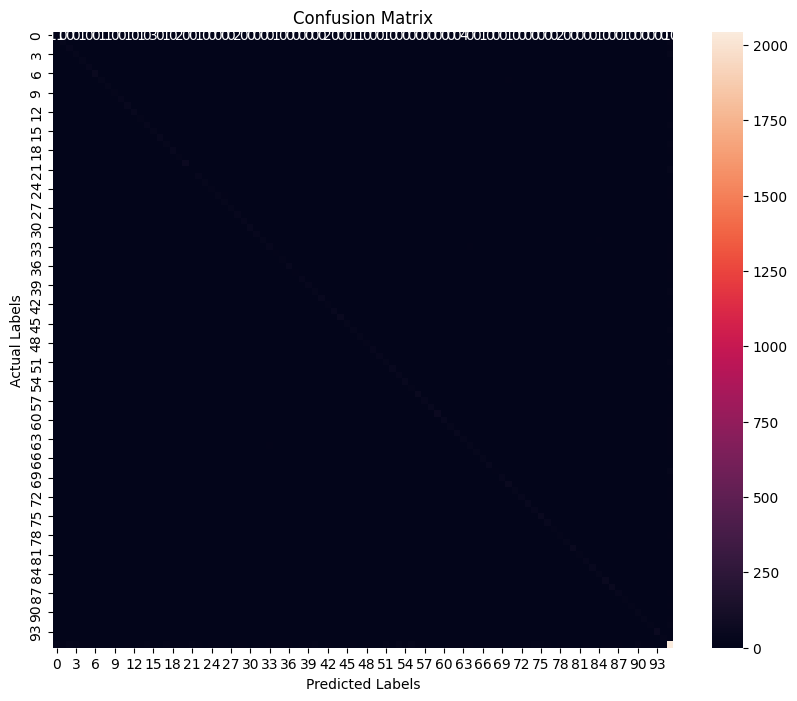

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_unmon_features, y_unmon, test_size=0.3, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)  # Adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Set up the grid of parameters to search
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# Initialize the k-NN Classifier and GridSearchCV
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, n_jobs=-1, verbose=1)

# Train the model with grid search
grid_search.fit(X_train_pca, y_train)

# Best parameter
print("Best parameter found: ", grid_search.best_params_)

# Train the classifier with the best number of neighbors
best_knn_clf = grid_search.best_estimator_

# Make predictions
y_pred = best_knn_clf.predict(X_test_pca)

# Calculate accuracy and other performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Generate and print a classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

### DB-Scan:

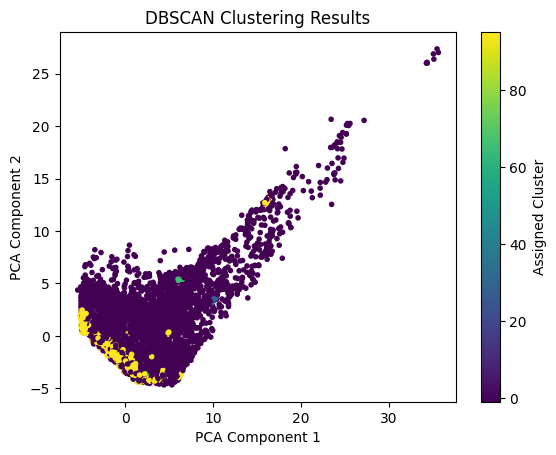

The number of clusters does not match the number of classes in y_unmon.


In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.metrics import classification_report

# Assuming X_unmon_features and y_unmon are your full dataset and labels
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unmon_features)

# Apply PCA
pca = PCA(n_components=0.95)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X_scaled)

# DBSCAN Clustering on PCA-transformed data
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_pca)

# Creating a label for each cluster based on the mode of the true labels in that cluster
labels_pred = np.zeros_like(clusters)
for cluster in np.unique(clusters):
    if cluster != -1:  # Ignore noise points
        mask = (clusters == cluster)
        labels_pred[mask] = mode(y_unmon[mask])[0]  # Taking the mode label

# Assign a unique label for noise points
noise_label = -1
labels_pred[clusters == -1] = noise_label

# Since DBSCAN is unsupervised and doesn't use y_unmon for clustering,
# the direct comparison to y_unmon might not be meaningful. Instead, consider the clusters' structure.

# Plotting the clusters (assuming 2D PCA for visualization)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_pred, cmap='viridis', marker='.')
plt.title('DBSCAN Clustering Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Assigned Cluster')
plt.show()

# If you still want to compare with y_unmon, use a classification report
# Note: This comparison assumes that the cluster labels can be directly compared to y_unmon,
# which might not be accurate for unsupervised clustering
if len(np.unique(y_unmon)) == len(np.unique(labels_pred)):
    print("\nClassification Report (Comparing Clusters with True Labels):\n")
    print(classification_report(y_unmon, labels_pred))
else:
    print("The number of clusters does not match the number of classes in y_unmon.")

### k-Means:

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


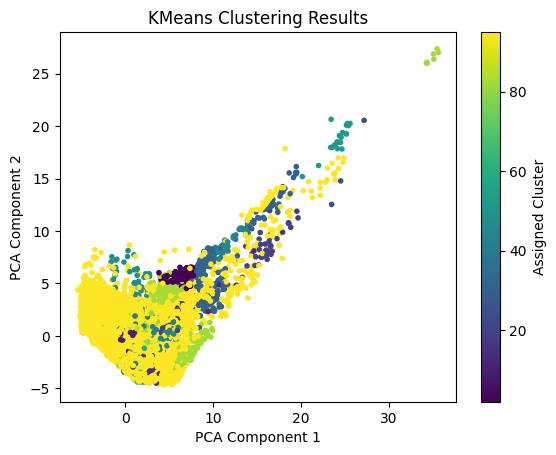


Classification Metrics (Comparing Clusters with True Labels):

Accuracy: 0.3723
Precision: 0.1864
Recall: 0.3723
F1-Score: 0.2389


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import mode
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unmon_features)

# Apply PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Determine the number of unique labels for KMeans
n_clusters = len(np.unique(y_unmon))

# KMeans Clustering on PCA-transformed data
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Assign the most frequent true label to each cluster
labels_pred = np.zeros_like(clusters)
for cluster in np.unique(clusters):
    mask = (clusters == cluster)
    labels_pred[mask] = mode(y_unmon[mask])[0]

# Plotting the clusters
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels_pred, cmap='viridis', marker='.')
plt.title('KMeans Clustering Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Assigned Cluster')
plt.show()

# Calculate and display classification metrics
print("\nClassification Metrics (Comparing Clusters with True Labels):\n")
accuracy = accuracy_score(y_unmon, labels_pred)
precision = precision_score(y_unmon, labels_pred, average='weighted')
recall = recall_score(y_unmon, labels_pred, average='weighted')
f1 = f1_score(y_unmon, labels_pred, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')


### Neuronal Network:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.constraints import MaxNorm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming X_unmon_features and y_unmon are your features and labels respectively

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unmon_features)

# Convert labels to categorical (one-hot encoding)
y_categorical = to_categorical(y_unmon)

# Split the data into training and testing sets, with shuffling
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.1, shuffle=True, random_state=42)

# Lower the dropout rate to reduce generalization
dropout_rate = 0.3  # Lowered dropout rate

# Define the optimizer with a modified learning rate schedule
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule)

# Add MaxNorm weight constraint
weight_constraint = MaxNorm(max_value=4, axis=0)

# Define the model with different architecture and complexity
model = Sequential([
    Dense(1024, input_dim=X_train.shape[1], kernel_constraint=weight_constraint),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(dropout_rate),
    Dense(768, kernel_constraint=weight_constraint),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(dropout_rate),
    Dense(512, kernel_constraint=weight_constraint),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(dropout_rate),
    Dense(256, kernel_constraint=weight_constraint),
    BatchNormalization(),
    LeakyReLU(alpha=0.01),
    Dropout(dropout_rate),
    Dense(y_categorical.shape[1], activation='softmax')
])

# Compile the model with the adjusted optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback with decreased patience to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model with an adjusted batch size and validation split
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=64,  # Adjusted batch size
    validation_split=0.1,  # Slightly reduced validation split
    verbose=1,
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Making predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate additional metrics
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()